In [ ]:
# OPF Swarming to Optimize Algorithm for Predictions (and the simulated data)

"""  Command line password edit for MySQL """
# export NTA_CONF_PROP_nupic_cluster_database_passwd=MySQL123

""" Run swarm """
# ~/nupic/scripts/run_swarm.py --overwrite ~/myswarm/data/search_def.json 


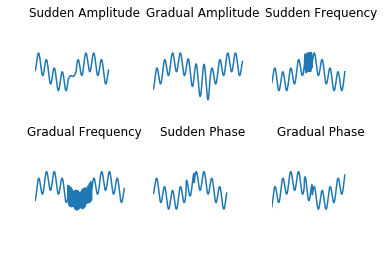

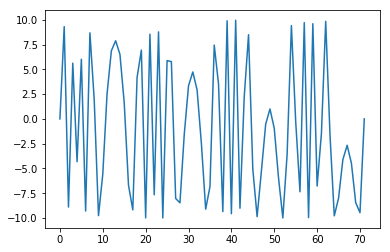

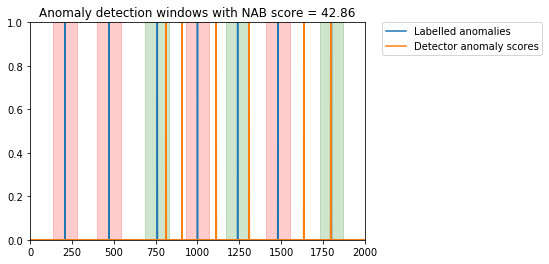

9998


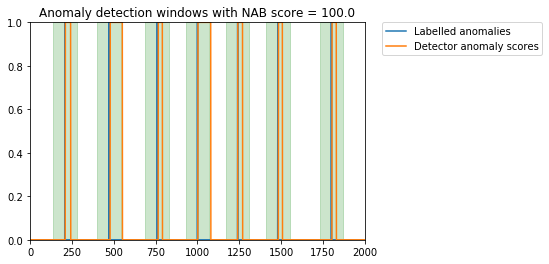

9998


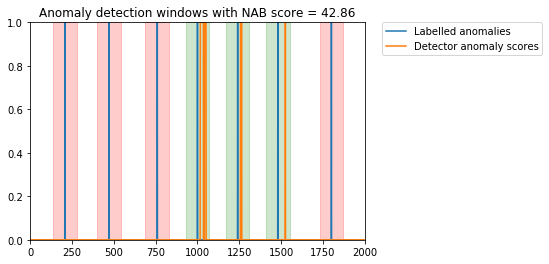

9998


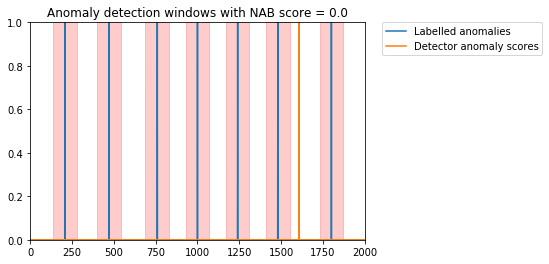

9998


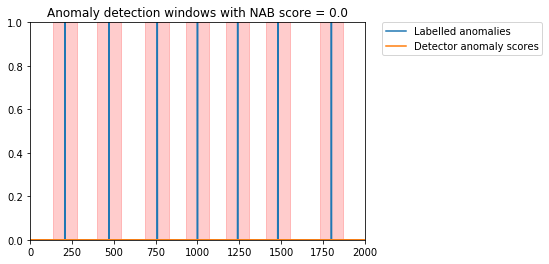

9998


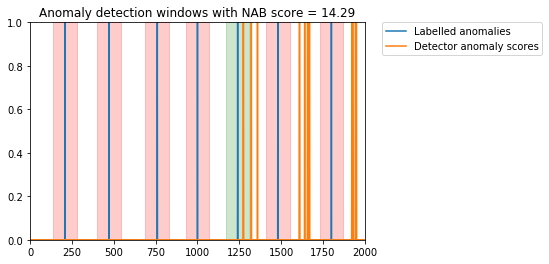

9998


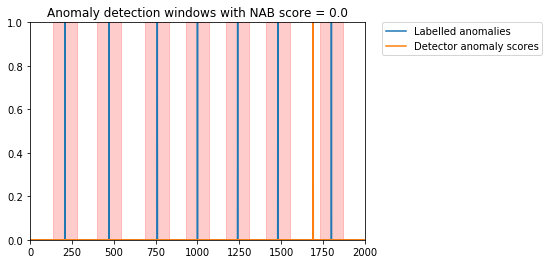

9998


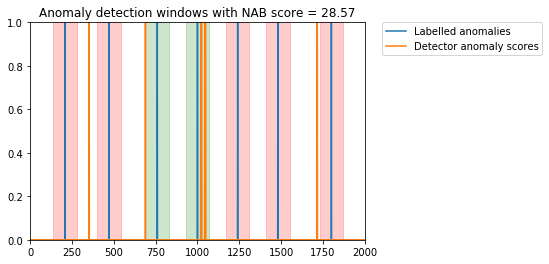

9998


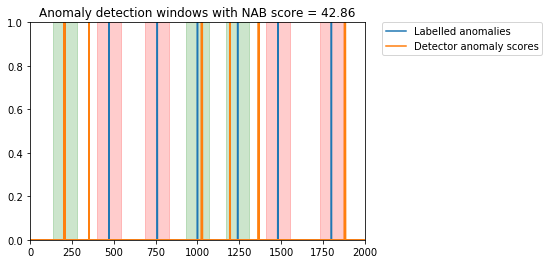

9998


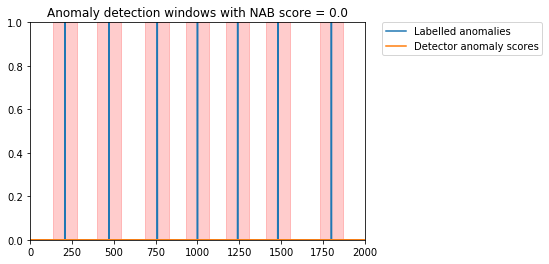

9998


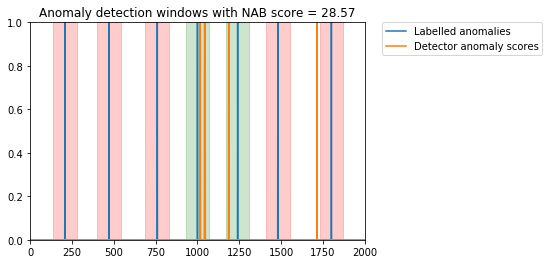

In [1]:
# Set up opf model and extract anomalies from data
import numpy as np
import matplotlib.pyplot as plt
import yaml
import csv
import datetime
from nupic.algorithms import anomaly_likelihood
from nupic.frameworks.opf.model_factory import ModelFactory
import importlib
from SimAnomalyDataset import get_data
import NABimplementation as NAB

# import simulated dataset
#data, anomaly_loc, anomaly_dur, dates = get_data(n,datalabels=datalabels)

def OPFHTM(raw_data = "sim_data.csv" ,datalabels=["timestamp","consumption"]):
    """
    Online Prediction Frame - HTM model adapted from Numenta example
    
    """
    # import model parameters["best_model_params" for default, or "model_params" for simulated swarmed"]
    modelParams = importlib.import_module("best_model_params").MODEL_PARAMS 

    # Create OPF Model & Load parameters into model space
    model = ModelFactory.create(modelParams)

    # Define prediction field
    model.enableInference({'predictedField': datalabels[1]})

    # Open the file to loop over each row to feed model
    output = []
    anomaly_score = []
    prediction = []
    confidence = []
    anomaly_Likelihood = []
    anomaly_logLikelihood = []
    anomaly_likelihood_helper = anomaly_likelihood.AnomalyLikelihood()
    input_data = []
    
    with open(raw_data) as fileIn:
        reader = csv.reader(fileIn)
        # The first two rows are not data, but we'll need the field names when passing data into the model.
        headers = reader.next()
        reader.next()
        reader.next()

        # loop through data rows
        for record in reader:
            # Save input data for plotting
            input_data.append(record)

            # Create a dictionary with field names as keys, row values as values.
            modelInput = dict(zip(headers, record))

            # Convert string consumption to float value.
            modelInput[datalabels[1]] = float(modelInput[datalabels[1]])

            # Convert timestamp string to Python datetime.
            modelInput[datalabels[0]] = datetime.datetime.strptime(
              modelInput[datalabels[0]], "%Y-%m-%d %H:%M:%S")

            # Push the data into the model and get back results.
            result = model.run(modelInput)

            # Save predicition history in new file
            output.append(result.inferences['multiStepBestPredictions'][1])

            anomaly_score_r = result.inferences["anomalyScore"]

            #prediction_r = result.inferences["multiStepBestPredictions"][1]

            #confidence.append(result.inferences["multiStepPredictions"][1][prediction_r])

            anomaly_Likelihood_r = anomaly_likelihood_helper.anomalyProbability(
                modelInput[datalabels[1]], anomaly_score_r, modelInput[datalabels[0]])

            anomaly_logLikelihood_r = anomaly_likelihood_helper.computeLogLikelihood(anomaly_Likelihood_r)

            #store for later
            #anomaly_score.append(anomaly_score_r)
            #prediction.append(prediction_r)
            #anomaly_Likelihood.append(anomaly_Likelihood_r)
            anomaly_logLikelihood.append(anomaly_logLikelihood_r)
    
    return anomaly_logLikelihood

In [ ]:
# # Testing noise in HTM simulations output data conversion -> output suitable for NAB
    
#     # Convert anomaly locations to binary array
#     labels = np.zeros_like(dates)
#     for i in anomaly_loc:
#         labels[i] = 1

#     # Threshold
#     cont = anomaly_logLikelihood[8000:]
#     cont = np.asarray(cont)
#     cont[cont<0.2] = 0
#     cont[cont>0.2] = 1

#     # Pad anomaly scores to zero during training
#     print(len(anomaly_logLikelihood))
#     full_anomaly_scores = np.zeros_like(dates)
#     full_anomaly_scores[8002:] = cont ############

#     # calculate NAB
#     NAB_noise.append(NAB.main(labels, full_anomaly_scores))

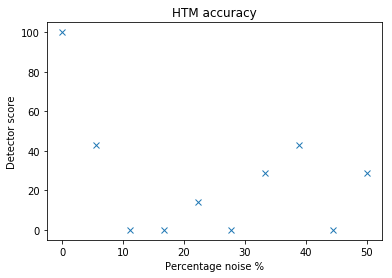

In [4]:
# # Plotter for HTM Accuracy
# x = np.linspace(0,0.5,10)*100
# plt.plot(x,NAB_noise,'x')
# #
# plt.xlabel("Percentage noise %")
# plt.ylabel("Detector score")
# #plt.xlim([0,100])
# #plt.ylim([0,100])
# plt.title('HTM accuracy')
# plt.show()

In [ ]:
# # Evaluate HTM as if it were a prediction generator (like LSTM)

# import numpy as np
# import evaluatePredictions as evalPred

# # slight data transformation
# a = np.asarray(input_data)
# a = a[:,2].astype(np.float)

# metric = "RMSE"
# OUT = evalPred.main(test=a[8000:], pred=prediction[8000:], metric = "MSE")

# #RMSE plot
# thresh_min = 200
# thresh_max = 500
# to_plot=np.asarray(OUT)
# to_plot[to_plot<thresh_min]=0
# to_plot[to_plot>thresh_max]=thresh_max
# to_plot = (to_plot/np.max(to_plot)) #remove normalizer whilst thresholding

# sim.plot_data((to_plot), anomaly_loc, anomaly_dur,title=metric)

# #anomaly likelihoods
# sim.plot_data((anomaly_score), anomaly_loc, anomaly_dur,title="anomaly_score")

In [ ]:
# pred=a[8000:]-prediction[8000:]
# evalPred.GaussianPredError(pred,anomaly_loc, anomaly_dur,thresh=0.97)